In [1]:
from cgi import print_form

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from statsmodels.sandbox.nonparametric.tests.ex_smoothers import weights
from statsmodels.tools import categorical
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import ADASYN




0.3138218924744773
[ 6.66133815e-16 -2.22044605e-16 -2.22044605e-16]
0.33439161306442083
[ 1.11022302e-16 -1.33226763e-15  2.22044605e-16]


In [ ]:
# Load the data
df = pd.read_parquet('../data/processed/num_imputed_df.parquet')
df = df.dropna(subset=['target'])
df.head()

# PCA

Creation of the training and test sets

In [ ]:
x_train, x_test = train_test_split(df, test_size=0.2, random_state=42)

Standarization

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

PCA

In [ ]:
pca = PCA(0.95)
pca.fit(x_train_scaled)
pca.n_components_

In [ ]:
# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
x_train_pca = pca.transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Create df for PCA components
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
x_train_pca_df = pd.DataFrame(x_train_pca, columns=pca_columns)
x_test_pca_df = pd.DataFrame(x_test_pca, columns=pca_columns)

print(x_train_pca_df.head())
print(x_test_pca_df.head())

Plot two Principal Components

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x_train_pca_df['PC1'], x_train_pca_df['PC2'], c=x_train['target'], cmap='viridis')
plt.title('PCA Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

# Feature selection

Load the data

In [37]:
df = pd.read_parquet('../data/processed/featured_df.parquet')
df = df.drop(['NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M'], axis=1)
df = df.dropna(subset=['target'])
df = df.reset_index(drop=True)
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,PHONE_CHANGE_BIRTH_PERCENT,MEDIAN_INCOME_CONTRACT_TYPE,MEDIAN_INCOME_SUITE_TYPE,MEDIAN_INCOME_HOUSING_TYPE,MEDIAN_INCOME_ORG_TYPE,MEDIAN_INCOME_OCCU_TYPE,MEDIAN_INCOME_EDU_TYPE,ORG_TYPE_INCOME_PERCENT,OCCU_TYPE_INCOME_PERCENT,EDU_TYPE_INCOME_PERCENT
0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,18.0,20.0,Secondary / secondary special,...,0.119860,153000.0,148500.0,144000.0,157500.0,157500.0,135000.0,0.777778,0.777778,0.666667
1,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,6.0,10.0,Higher education,...,0.049389,153000.0,144000.0,148500.0,135000.0,157500.0,180000.0,0.500000,0.583333,0.666667
2,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,16.0,17.0,Secondary / secondary special,...,0.042791,135000.0,153000.0,148500.0,144000.0,157500.0,135000.0,2.133333,2.333333,2.000000
3,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,20.0,16.0,Secondary / secondary special,...,0.032465,153000.0,157500.0,153000.0,157500.0,157500.0,135000.0,1.166667,1.166667,1.000000
4,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,16.0,17.0,Secondary / secondary special,...,0.055489,153000.0,153000.0,148500.0,157500.0,157500.0,135000.0,1.296296,1.296296,1.111111


In [38]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(exclude=['object', 'category']).columns

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False,drop='first')
encoded_categorical = encoder.fit_transform(df[categorical_cols])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))

df = pd.concat([encoded_categorical_df, df[numerical_cols]], axis=1)
df.head()

,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,...,PHONE_CHANGE_BIRTH_PERCENT,MEDIAN_INCOME_CONTRACT_TYPE,MEDIAN_INCOME_SUITE_TYPE,MEDIAN_INCOME_HOUSING_TYPE,MEDIAN_INCOME_ORG_TYPE,MEDIAN_INCOME_OCCU_TYPE,MEDIAN_INCOME_EDU_TYPE,ORG_TYPE_INCOME_PERCENT,OCCU_TYPE_INCOME_PERCENT,EDU_TYPE_INCOME_PERCENT
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.119860,153000.0,148500.0,144000.0,157500.0,157500.0,135000.0,0.777778,0.777778,0.666667
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.049389,153000.0,144000.0,148500.0,135000.0,157500.0,180000.0,0.500000,0.583333,0.666667
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.042791,135000.0,153000.0,148500.0,144000.0,157500.0,135000.0,2.133333,2.333333,2.000000
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.032465,153000.0,157500.0,153000.0,157500.0,157500.0,135000.0,1.166667,1.166667,1.000000
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.055489,153000.0,153000.0,148500.0,157500.0,157500.0,135000.0,1.296296,1.296296,1.111111


In [39]:
# Split the data
X = df.drop('target', axis=1)
y = df['target']

#### Variance Threshold

In [40]:
# Scale the features, using MinMaxScaler
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Calculate the variance of each feature
variances = scaled_X.var(axis=0)

# Sort the variances in descending order
sorted_indices = np.argsort(-variances)
sorted_variances = variances[sorted_indices]
sorted_columns = X.columns[sorted_indices]

# Print the sorted variances
for col, var in zip(sorted_columns, sorted_variances):
    print(f"{col}: {var}")

CODE_GENDER_M: 0.22492521745609442
FLAG_OWN_CAR: 0.22443362255532046
FLAG_OWN_REALTY: 0.21249056103388153
FLAG_DOCUMENT_3: 0.20588554817848845
NAME_EDUCATION_TYPE_Secondary / secondary special: 0.20581858542736894
FLAG_PHONE: 0.20206597113408414
NAME_EDUCATION_TYPE_Higher education: 0.18417982500446584
REG_CITY_NOT_WORK_CITY: 0.17734659146257514
FLAG_WORK_PHONE: 0.15961441967744427
FLAG_EMP_PHONE: 0.14767208310129792
LIVE_CITY_NOT_WORK_CITY: 0.1473159990241992
OCCUPATION_TYPE_Laborers: 0.14725763393240773
WEEKDAY_APPR_PROCESS_START_TUESDAY: 0.14455702601657505
WEEKDAY_APPR_PROCESS_START_WEDNESDAY: 0.14036614037766804
WEEKDAY_APPR_PROCESS_START_MONDAY: 0.1377208926935142
WEEKDAY_APPR_PROCESS_START_THURSDAY: 0.13745266984113996
DAYS_EMPLOYED: 0.13595298335654188
WEEKDAY_APPR_PROCESS_START_SATURDAY: 0.09796792172981059
OCCUPATION_TYPE_Sales staff: 0.09349752975254846
NAME_CONTRACT_TYPE_Revolving loans: 0.08613645870908841
MEDIAN_INCOME_CONTRACT_TYPE: 0.08613645870908841
OCCUPATION_TYPE_Co

Plotting the variance of the features

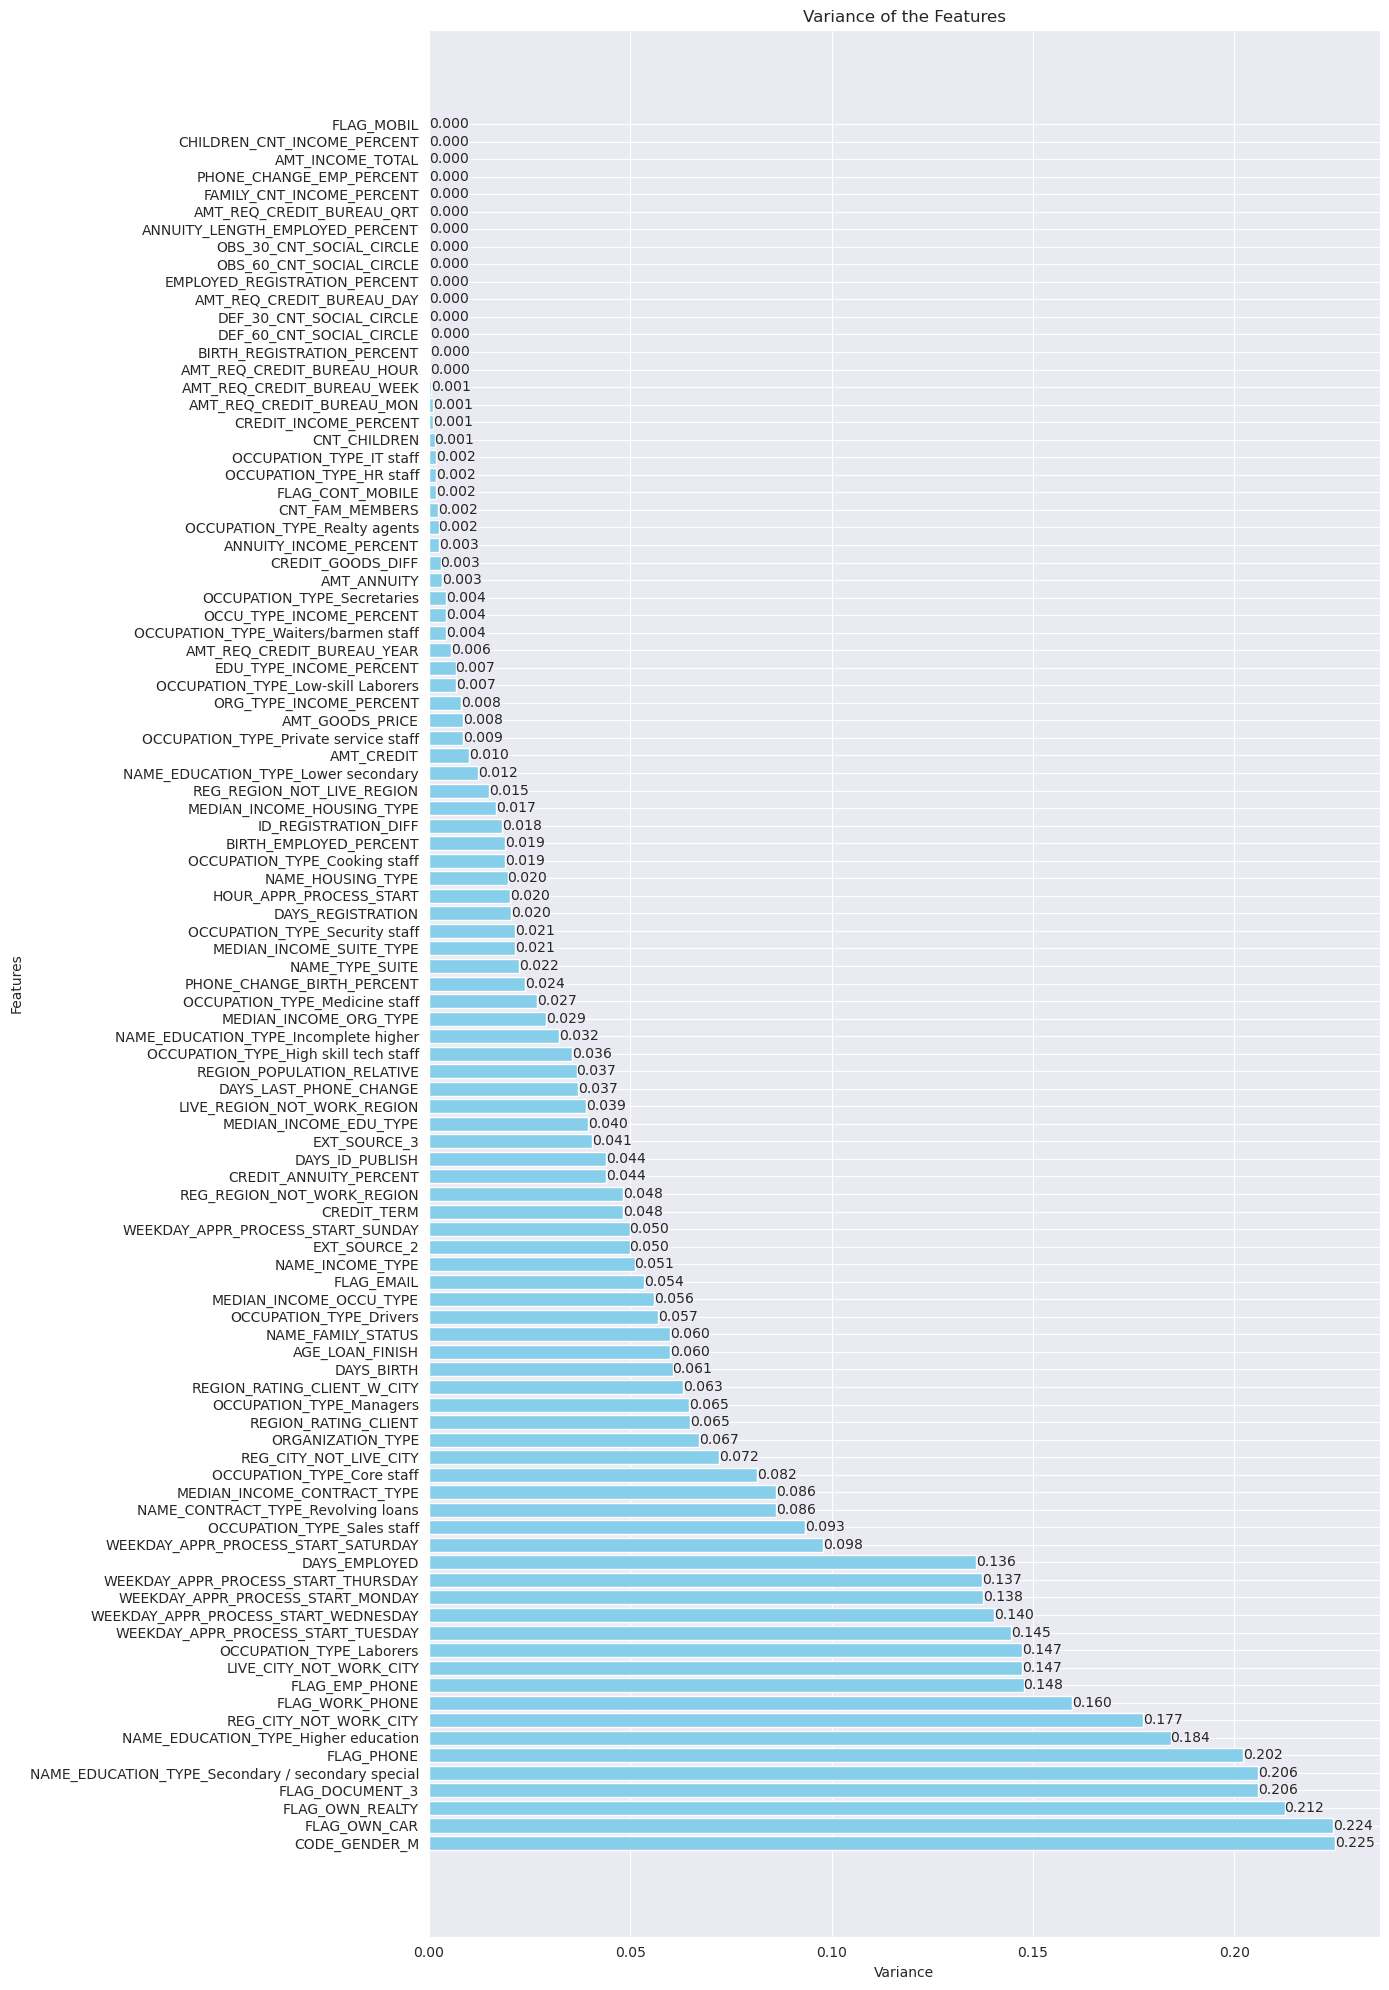

In [41]:
import matplotlib.pyplot as plt

top_variances = sorted_variances
top_columns = sorted_columns

plt.figure(figsize=(14, 20))  
bars = plt.barh(top_columns, top_variances, color='skyblue')  
plt.xlabel('Variance')
plt.ylabel('Features')
plt.title(f'Variance of the Features')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left', fontsize=10)

plt.tight_layout()  
plt.show()


We are going to select the features with a variance greater than 0.01

In [42]:
varianceSelector = VarianceThreshold(threshold=0.001)
varianceSelector.fit(scaled_X)

selected_features_mask = varianceSelector.get_support()

selected_features = X.columns[selected_features_mask]
discarded_features = X.columns[~selected_features_mask]

print(f"Selected features: {selected_features}")
print(f"Discarded features: {discarded_features}")
print(f"Number of selected features: {len(selected_features)}")
print(f"Number of discarded features: {len(discarded_features)}")

Selected features: Index(['NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'WEEKDAY_APPR_PROCESS_START_MONDAY',
       'WEEKDAY_APPR_PROCESS_START_SATURDAY',
       'WEEKDAY_APPR_PROCESS_START_SUNDAY',
       'WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'OCCUPATION_TYPE_Cooking staff',
       'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers',
       'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_High skill tech staff',
       'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Laborers',
       'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
       'OCCUPATION_TYPE_Medicine staff',
       'OCCUPATION_TYPE_Private service staff',
       'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff',
       'OCCUPATION_TYPE_Secretaries', '

In [43]:
X = X[selected_features]
X.head()

,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,...,PHONE_CHANGE_BIRTH_PERCENT,MEDIAN_INCOME_CONTRACT_TYPE,MEDIAN_INCOME_SUITE_TYPE,MEDIAN_INCOME_HOUSING_TYPE,MEDIAN_INCOME_ORG_TYPE,MEDIAN_INCOME_OCCU_TYPE,MEDIAN_INCOME_EDU_TYPE,ORG_TYPE_INCOME_PERCENT,OCCU_TYPE_INCOME_PERCENT,EDU_TYPE_INCOME_PERCENT
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.119860,153000.0,148500.0,144000.0,157500.0,157500.0,135000.0,0.777778,0.777778,0.666667
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.049389,153000.0,144000.0,148500.0,135000.0,157500.0,180000.0,0.500000,0.583333,0.666667
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.042791,135000.0,153000.0,148500.0,144000.0,157500.0,135000.0,2.133333,2.333333,2.000000
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.032465,153000.0,157500.0,153000.0,157500.0,157500.0,135000.0,1.166667,1.166667,1.000000
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.055489,153000.0,153000.0,148500.0,157500.0,157500.0,135000.0,1.296296,1.296296,1.111111


#### Recursive Feature Elimination (RFE)

Creation of the training and test sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Oversampling using ADASYN

In [36]:
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
scaler = MinMaxScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)
X_train_res = pd.DataFrame(X_train_res, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

/home/aitor/anaconda3/envs/rapids-24.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [13]:
rfe_score = {}
rfe_features = {}

iterations = 0

for k in range(10,70,5):
    xgb = XGBClassifier(tree_method='hist', device = "cuda",random_state = 42, scale_pos_weight = 8)  # Configurado para usar GPU
    
    print(f"Training RFE")
    RFE_selector = RFE(xgb, n_features_to_select=k, step=3)
    RFE_selector.fit(X_train_res, y_train_res)
    print("RFE Done!")
    
    sel_x_train = RFE_selector.transform(X_train_res)
    sel_x_test = RFE_selector.transform(X_test)
    
    print("Training the model")
    xgb.fit(sel_x_train, y_train_res)
    RFE_preds = xgb.predict(sel_x_test)
    print("Model Done!")
    
    score = round(f1_score(y_test, RFE_preds), 5)
    rfe_score[k] = score
    rfe_features[k] = X_train.columns[RFE_selector.get_support()]
    iterations += 1
    print(f'Iteration {iterations} with {k} features: {score}')
    #print(f'Selected features: {rfe_features[k]}')
    print("-"*100)

Oversampling Done!
Scaling Done!
Training RFE


/home/aitor/anaconda3/envs/rapids-24.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


RFE Done!
Training the model


/home/aitor/anaconda3/envs/rapids-24.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:39:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1727241199541/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Model Done!
Iteration 1 with 10 features: 0.06247
----------------------------------------------------------------------------------------------------
Training RFE
RFE Done!
Training the model
Model Done!
Iteration 2 with 15 features: 0.1328
----------------------------------------------------------------------------------------------------
Training RFE
RFE Done!
Training the model
Model Done!
Iteration 3 with 20 features: 0.14647
----------------------------------------------------------------------------------------------------
Training RFE
RFE Done!
Training the model
Model Done!
Iteration 4 with 25 features: 0.1448
----------------------------------------------------------------------------------------------------
Training RFE
RFE Done!
Training the model
Model Done!
Iteration 5 with 30 features: 0.14061
----------------------------------------------------------------------------------------------------
Training RFE
RFE Done!
Training the model
Model Done!
Iteration 6 with 35 featu

Plot the results

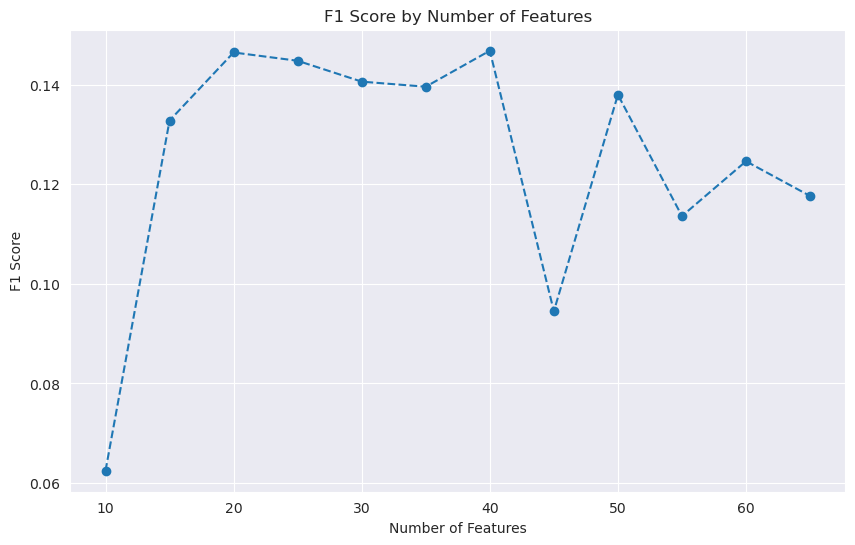

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(list(rfe_score.keys()), list(rfe_score.values()), marker='o', linestyle='--')
plt.title('F1 Score by Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


Select k best features

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

selectorKbest = SelectKBest(f_classif, k=40)
selectorKbest.fit(X_train_res, y_train_res)

X_train_res = selectorKbest.transform(X_train_res)
X_test = selectorKbest.transform(X_test)

In [26]:
X[selected_features]

,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,...,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,ID_REGISTRATION_DIFF,AGE_LOAN_FINISH,MEDIAN_INCOME_SUITE_TYPE,MEDIAN_INCOME_HOUSING_TYPE,MEDIAN_INCOME_EDU_TYPE,ORG_TYPE_INCOME_PERCENT
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.262949,0.139376,-1134.0,1.0,1528.0,27.292307,148500.0,144000.0,135000.0,0.777778
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.622246,0.628502,-828.0,1.0,895.0,48.951014,144000.0,148500.0,180000.0,0.500000
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.555912,0.729567,-815.0,0.0,1729.0,53.847489,153000.0,148500.0,135000.0,2.133333
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.650442,0.737596,-617.0,1.0,7396.0,52.946228,157500.0,153000.0,135000.0,1.166667
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.322738,0.518093,-1106.0,0.0,853.0,56.563354,153000.0,148500.0,135000.0,1.296296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307497,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.681632,0.511744,-273.0,0.0,6474.0,26.323618,155475.0,135000.0,135000.0,1.000000
307498,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.115992,0.561040,0.0,1.0,298.0,58.789449,148500.0,144000.0,135000.0,1.562500
307499,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.535722,0.218859,-1909.0,1.0,1587.0,42.886458,155475.0,148500.0,180000.0,0.882353
307500,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.514163,0.661024,-322.0,1.0,1631.0,34.296329,155475.0,148500.0,135000.0,0.921053


Studying the best model

In [19]:
best_features = rfe_features[40]
best_features

Index(['NAME_EDUCATION_TYPE_Secondary / secondary special',
       'WEEKDAY_APPR_PROCESS_START_MONDAY',
       'WEEKDAY_APPR_PROCESS_START_SATURDAY',
       'WEEKDAY_APPR_PROCESS_START_SUNDAY',
       'WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'OCCUPATION_TYPE_Core staff',
       'OCCUPATION_TYPE_Sales staff', 'CODE_GENDER_M', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU

Saving the results

In [44]:
X.head()

,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,...,PHONE_CHANGE_BIRTH_PERCENT,MEDIAN_INCOME_CONTRACT_TYPE,MEDIAN_INCOME_SUITE_TYPE,MEDIAN_INCOME_HOUSING_TYPE,MEDIAN_INCOME_ORG_TYPE,MEDIAN_INCOME_OCCU_TYPE,MEDIAN_INCOME_EDU_TYPE,ORG_TYPE_INCOME_PERCENT,OCCU_TYPE_INCOME_PERCENT,EDU_TYPE_INCOME_PERCENT
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.119860,153000.0,148500.0,144000.0,157500.0,157500.0,135000.0,0.777778,0.777778,0.666667
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.049389,153000.0,144000.0,148500.0,135000.0,157500.0,180000.0,0.500000,0.583333,0.666667
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.042791,135000.0,153000.0,148500.0,144000.0,157500.0,135000.0,2.133333,2.333333,2.000000
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.032465,153000.0,157500.0,153000.0,157500.0,157500.0,135000.0,1.166667,1.166667,1.000000
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.055489,153000.0,153000.0,148500.0,157500.0,157500.0,135000.0,1.296296,1.296296,1.111111


In [45]:
# Merge the target column
df = X.copy()
df['target'] = y

df.to_parquet('../data/processed/selected_features_df.parquet')